##  Disease detection using CNN on X-ray Images

### Importing all the relevant modules

In [3]:
import numpy as np
import pandas as pd
from PIL import Image
import os
from random import random
from random import seed
import time
from datetime import datetime, timedelta
from numpy import expand_dims
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
from keras.layers import Input, Dense, Flatten, Reshape
from keras.models import Model, Sequential
from keras.layers import Dropout
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.utils import Sequence
from keras.utils import to_categorical

Using TensorFlow backend.


In [4]:
# Auxilliary Functions to record execution time

def secondsToTime(seconds):
    min, sec = divmod(seconds, 60) 
    hour, min = divmod(min, 60) 
    return "%d:%02d:%02d" % (hour, min, sec) + " h:m:s"

def printElapsedTime(startTime):
    endTime = time.time()
    totalTime = endTime - startTime
    print("Elapsed time:",secondsToTime(totalTime))

### Labeling data and splitting data set to train and validation set 

In [5]:
# Folders in the directory containing the images

folders = ['Type A','Type B','Type C','NORMAL']

In [6]:
# Create labels for different diseases
labels_value = {'Type A' : 0, 'Type B' : 1, 'Type C' : 2, 'NORMAL' : 3}
partition = {'train' : [], 'validation' : []}
labels = {}
image_name  = []
image_label = []

In [7]:
for dir in folders:
    for filename in os.listdir(dir):
        
        # Append the folder name and file name to image_name
        ID = str(dir+'/'+filename)
        image_name.append(ID)
        
        # Append the label of the image to image_label
        image_label.append(dir)
        
        # Create a key value pair for image name and the label
        labels[ID] = labels_value[dir]

In [8]:
# Total Number of files:

print(len(image_name))

2389


In [9]:
# Split the files into training and validation set 

X_train, X_test, y_train, y_test = train_test_split(image_name, image_label, test_size=0.15, random_state=42)

In [10]:
# Number of images in test and train for each disease

def display_count(data):
    count = {'Type A' : 0, 'Type B' : 1, 'Type C' : 2, 'NORMAL' : 3}
    for label in data:
        count[label] += 1
    print(count)

print('Distribution of training data set:')
display_count(y_train)

print('Distribution of validation data set:')
display_count(y_test)

Distribution of training data set:
{'Type A': 540, 'Type B': 228, 'Type C': 238, 'NORMAL': 1030}
Distribution of validation data set:
{'Type A': 102, 'Type B': 26, 'Type C': 50, 'NORMAL': 187}


In [11]:
print('Total number of Training set: ',len(X_train))
print('Total number of Validation set: ',len(X_test))

Total number of Training set:  2030
Total number of Validation set:  359


## Creating data generators for training the images with less computational overhead

In [52]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size, dim, n_channels,
                 n_classes, shuffle):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        
        'Generate one batch of data'
        # Generate indexes of the batch
        #indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        #list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        #X, y = self.__data_generation(list_IDs_temp)
        
        
        idx_min = index*self.batch_size
        idx_max = min(idx_min + self.batch_size, len(self.list_IDs))
        indexes = self.indexes[idx_min: idx_max]
        
        
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):

            img = Image.open(ID)
            array = np.asarray(img)
            shape = array.shape

            # Convert the shape of image to 1-D
            if len(shape) == 3:
                img = img.convert('L')

            # Resize the images to 256 x 256:
            img = img.resize((256,256))
                
            array = np.asarray(img)
            
            
            array = array/255
                
            data_last = expand_dims(array, axis=2)
            
            X[i,] = data_last

            # Store class
            y[i] = self.labels[ID]

        return X, to_categorical(y, num_classes=self.n_classes)

In [13]:
# Parameters
params = {'dim': (256,256),
          'batch_size': 10,
          'n_classes': 4,
          'n_channels': 1,
          'shuffle': False}

In [18]:
def larger_model():
    # create model
    model = Sequential()
    model.add(Conv2D(50, (3,3), input_shape=(256, 256,1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))
    model.add(Conv2D(25, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(15, (2, 2), activation='relu'))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(4, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

## Model trained with 93% validation accuracy


In [53]:
# Generators
training_generator = DataGenerator(X_train, labels, **params)
validation_generator = DataGenerator(X_test, labels, **params)

In [24]:
# build the model
model = larger_model()

In [25]:
seed(42)
startTime = time.time()

# Train model on dataset
model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=False,
                    
                    epochs = 10)

printElapsedTime(startTime)

Epoch 1/10
203/203 [==============================] - 85s 420ms/step - loss: 0.6519 - acc: 0.7394 - val_loss: 0.3417 - val_acc: 0.8314
Epoch 2/10
203/203 [==============================] - 85s 419ms/step - loss: 0.3743 - acc: 0.8645 - val_loss: 0.2843 - val_acc: 0.8914
Epoch 3/10
203/203 [==============================] - 88s 435ms/step - loss: 0.2513 - acc: 0.9103 - val_loss: 0.3066 - val_acc: 0.8914
Epoch 4/10
203/203 [==============================] - 89s 439ms/step - loss: 0.1884 - acc: 0.9365 - val_loss: 0.2434 - val_acc: 0.9171
Epoch 5/10
203/203 [==============================] - 90s 442ms/step - loss: 0.1188 - acc: 0.9567 - val_loss: 0.2597 - val_acc: 0.9343
Epoch 6/10
203/203 [==============================] - 90s 444ms/step - loss: 0.0923 - acc: 0.9635 - val_loss: 0.2935 - val_acc: 0.9171
Epoch 7/10
203/203 [==============================] - 92s 451ms/step - loss: 0.0752 - acc: 0.9754 - val_loss: 0.2236 - val_acc: 0.9371
Epoch 8/10
203/203 [==============================] - 8

### Confusion Matrix of the results

In [54]:
# Get the prediction results from the model

scores = model.predict_generator(validation_generator)
predicted_class_indices=np.argmax(scores,axis=1)

In [87]:
# Get labels of test set

test_labels = [labels_value[k] for k in y_test]

In [85]:
# Create confusion Matrix 

cm = confusion_matrix(predictions,predicted_class_indices[0:359])

In [82]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [83]:
cm_plot_labels = ['Type A','Type B', 'Type C', 'NORMAL']

Confusion matrix, without normalization
[[ 94   0   1   7]
 [  0  20   5   0]
 [  1   4  43   0]
 [  1   1   1 181]]


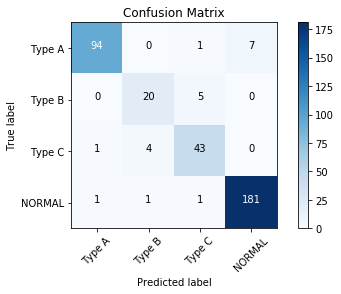

In [86]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

#### Insights:

- Type B and Type C are very similar effects on the lungs. 
- More fine details need to be captured to distinguish Type B and C better. We need to go deeper and more complexx CNN, but also more data for these diseases.
- Type A is distinguishable from Type B and Type C, but few cases might have been detected at a nascent stage or might not have severe affect on the lungs